![](https://scoutium.com/_nuxt/img/banner.60ba99f.png)


<div style="border: 1px solid gray;
            margin-left: auto;
            margin-right: auto;
            width: 90%;
            background-color: #5AC493;
            text-align: left;
            padding: 8px;
            font-size: 17px;
            font-family: Tahoma;">
    
<h1 style=''>GOAL</h1>
  <p>Scoutium makes you visible to clubs by providing your match videos & robust scout analyses of your performances. There are millions of soccer players around the world. Scoutium goes with mission to allow all the talented players and scouts in the world to be discovered. With the dataset full of players, attributes and ratings given by scouts is it possible to predict potential of players ?

</p>
</div>

<h2 style=''>Importing Libraries</h2>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

#models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate, validation_curve

pd.set_option('display.max_columns',None)
pd.options.display.float_format = '{:,.2f}'.format

<h2 style=''>Loading Datasets</h2>

* task_response_id: Set of a scout's assessments of all players on a team's roster in a match
* match_id: Match id. 
* evaluator_id: Scout id.
* player_id: Player id.
* position_id: Position id.
    <br>
    1. Goalkeeper
    <br>
    2. Central Back
    <br>
    3. Right Back
    <br>
    4. Left Back
    <br>
    5. Central Defensive Midfielder
    <br>
    6. Central Midfielder
    <br>
    7. Right Wing
    <br>
    8. Left Wing
    <br>
    9. Central Attacking Midfielder
    <br>
    10. Forward
* analysis_id: A set containing a scout's attribute evaluations of a player in a match.
* attribute_id: Attribute id.
* attribute_value: Attribute value given by scout.

In [2]:
df_attributes = pd.read_csv('../input/scoutium/scoutium_attributes.csv',sep=';')

In [3]:
df_attributes.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value
0,4915,62935,177676,1361061,2,12818495,4322,56.00
1,4915,62935,177676,1361061,2,12818495,4323,56.00
2,4915,62935,177676,1361061,2,12818495,4324,67.00
3,4915,62935,177676,1361061,2,12818495,4325,56.00
4,4915,62935,177676,1361061,2,12818495,4326,45.00


In [4]:
df_label = pd.read_csv('../input/scoutium/scoutium_potential_labels.csv',sep=';')

In [5]:
df_label.head()

,task_response_id,match_id,evaluator_id,player_id,potential_label
0,4915,62935,177676,1361061,average
1,4915,62935,177676,1361626,highlighted
2,4915,62935,177676,1361858,average
3,4915,62935,177676,1362220,highlighted
4,4915,62935,177676,1364951,highlighted


<div class="alert alert-block alert-success" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    ✔ &nbsp; Attributes and labels are given seperately. First mission is merging them into one ! 
</div>

In [6]:
merged_df = pd.merge(df_attributes,df_label)
merged_df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.00,average
1,4915,62935,177676,1361061,2,12818495,4323,56.00,average
2,4915,62935,177676,1361061,2,12818495,4324,67.00,average
3,4915,62935,177676,1361061,2,12818495,4325,56.00,average
4,4915,62935,177676,1361061,2,12818495,4326,45.00,average


<div class="alert alert-block alert-success" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    ✔ &nbsp; Dataset format is not quite what we want. There should be one row for every player_id - position_id combination with attributes as columns.
</div>

In [7]:
# analysis_id doesnt contain any useful information
merged_df.drop('analysis_id',axis=1,inplace=True)

<h2 style=''>Reshaping Dataset</h2>

In [8]:
df_players = merged_df.pivot_table(index= ['player_id', 'position_id', 'potential_label'], 
                                   columns='attribute_id', 
                                   values='attribute_value').reset_index()

In [9]:
df_players.columns = df_players.columns.map(str)
df_players.columns = df_players.columns.str.replace(' ','')

In [10]:
df_players.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4336,4337,4338,4339,4340,4341,4342,4343,4344,4345,4346,4347,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4409,4423,4426
0,1355710,7,average,50.50,50.50,34.00,50.50,45.00,45.00,45.00,45.00,50.50,56.00,39.50,34.00,NaN,NaN,39.50,39.50,45.00,45.00,50.50,28.50,23.00,39.50,NaN,NaN,28.50,28.50,45.00,50.50,56.00,34.00,39.50,50.50,34.00,34.00,56.00,34.00,NaN,34.00,56.00
1,1356362,9,average,67.00,67.00,67.00,67.00,67.00,67.00,67.00,67.00,67.00,67.00,67.00,67.00,NaN,NaN,67.00,67.00,67.00,67.00,67.00,67.00,56.00,67.00,NaN,NaN,67.00,56.00,67.00,67.00,67.00,67.00,78.00,67.00,67.00,67.00,67.00,67.00,NaN,56.00,78.00
2,1356375,3,average,67.00,67.00,67.00,67.00,67.00,67.00,67.00,78.00,67.00,67.00,78.00,56.00,NaN,NaN,67.00,67.00,67.00,67.00,67.00,56.00,56.00,67.00,NaN,NaN,67.00,56.00,56.00,67.00,67.00,67.00,78.00,67.00,67.00,67.00,67.00,67.00,NaN,56.00,78.00
3,1356375,4,average,67.00,78.00,67.00,67.00,67.00,78.00,78.00,78.00,56.00,67.00,67.00,67.00,NaN,NaN,78.00,78.00,56.00,67.00,67.00,45.00,45.00,56.00,NaN,NaN,67.00,67.00,67.00,67.00,78.00,67.00,67.00,67.00,56.00,67.00,56.00,67.00,NaN,45.00,56.00
4,1356378,4,below_average,67.00,67.00,45.00,56.00,67.00,67.00,67.00,67.00,45.00,67.00,67.00,56.00,NaN,NaN,67.00,67.00,56.00,56.00,67.00,34.00,34.00,56.00,NaN,NaN,67.00,67.00,67.00,56.00,67.00,56.00,67.00,67.00,56.00,67.00,67.00,78.00,NaN,45.00,56.00


<h2 style=''>Exploration</h2>

In [11]:
df_players.describe().T

,count,mean,std,min,25%,50%,75%,max
attribute_id,,,,,,,,
player_id,301.00,"1,534,566.23","203,335.45","1,355,710.00","1,368,237.00","1,372,695.00","1,719,681.00","1,909,728.00"
position_id,301.00,5.24,2.89,1.00,2.00,5.00,8.00,10.00
4322,301.00,58.19,14.75,23.00,45.00,56.00,67.00,89.00
4323,301.00,58.55,15.08,23.00,45.00,56.00,67.00,89.00
4324,301.00,55.60,16.17,23.00,45.00,56.00,67.00,78.00
4325,301.00,56.44,14.95,12.00,45.00,56.00,67.00,89.00
4326,301.00,55.90,15.10,23.00,45.00,56.00,67.00,89.00
4327,301.00,56.42,14.65,23.00,45.00,56.00,67.00,78.00
4328,301.00,58.00,14.94,23.00,45.00,56.00,67.00,89.00


<div class="alert alert-block alert-success" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📝 &nbsp; Each feature have ratings in range 0-100. So there is no work to do here.
</div>

<span style=''>
<img style='width:250px; height:450px;', src='https://www.researchgate.net/profile/Toni-Modric-2/publication/345241922/figure/fig1/AS:953752978722817@1604403838723/Team-formation-with-main-and-specific-playing-positions-in-soccer-game.png'></img>
</span>

<AxesSubplot:xlabel='position_id', ylabel='count'>

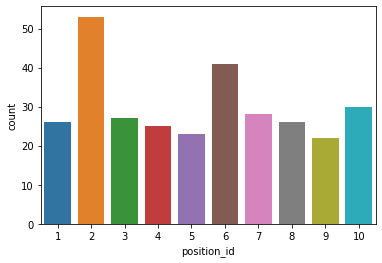

In [12]:
# player counts by positions
sns.countplot(x= df_players.position_id)

<AxesSubplot:xlabel='potential_label', ylabel='count'>

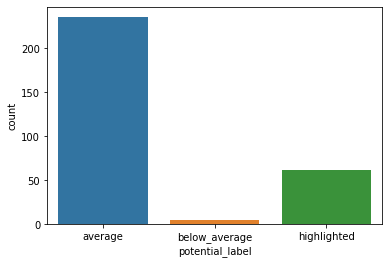

In [13]:
# label distribution
sns.countplot(x= df_players.potential_label)

In [14]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 42 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   player_id        301 non-null    int64  
 1   position_id      301 non-null    int64  
 2   potential_label  301 non-null    object 
 3   4322             301 non-null    float64
 4   4323             301 non-null    float64
 5   4324             301 non-null    float64
 6   4325             301 non-null    float64
 7   4326             301 non-null    float64
 8   4327             301 non-null    float64
 9   4328             301 non-null    float64
 10  4329             301 non-null    float64
 11  4330             301 non-null    float64
 12  4332             301 non-null    float64
 13  4333             275 non-null    float64
 14  4335             275 non-null    float64
 15  4336             26 non-null     float64
 16  4337             26 non-null     float64
 17  4338            

<h2 style=''>Missing Values</h2>

In [15]:
def missing_values_table(dataframe, printer=False, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    
    if printer:
        print(missing_df, end="\n")

In [16]:
missing_values_table(df_players, printer= True)

              n_miss  ratio
attribute_id               
4409             275  91.36
4347             275  91.36
4336             275  91.36
4337             275  91.36
4346             275  91.36
4408              26   8.64
4407              26   8.64
4356              26   8.64
4351              26   8.64
4349              26   8.64
4348              26   8.64
4333              26   8.64
4335              26   8.64
4344              26   8.64
4343              26   8.64
4341              26   8.64
4340              26   8.64
4339              26   8.64
4345              26   8.64


<div class="alert alert-block alert-success" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📝 &nbsp; Now its easily say that there is a pattern in the missing values. First thing to check is Goalkeepers. A scout can't rate shooting, defending or jumping of goalkeeper. Diving and GK Reflexes are Goalkeeper only attributes. Let's check our first assumption.
</div>

In [17]:
df_players[~df_players['4409'].isna()].head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4336,4337,4338,4339,4340,4341,4342,4343,4344,4345,4346,4347,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4409,4423,4426
7,1356422,1,average,67.00,67.00,56.00,56.00,67.00,67.00,78.00,78.00,56.00,67.00,NaN,NaN,78.00,56.00,78.00,NaN,NaN,NaN,56.00,NaN,NaN,NaN,45.00,78.00,NaN,NaN,78.00,NaN,67.00,67.00,78.00,67.00,NaN,78.00,NaN,NaN,67.00,56.00,56.00
8,1358072,1,average,56.00,56.00,45.00,45.00,45.00,45.00,45.00,45.00,34.00,45.00,NaN,NaN,45.00,45.00,34.00,NaN,NaN,NaN,34.00,NaN,NaN,NaN,45.00,56.00,NaN,NaN,45.00,NaN,45.00,45.00,45.00,45.00,NaN,45.00,NaN,NaN,45.00,23.00,34.00
9,1358124,1,average,45.00,45.00,34.00,45.00,45.00,56.00,56.00,45.00,45.00,45.00,NaN,NaN,34.00,34.00,45.00,NaN,NaN,NaN,45.00,NaN,NaN,NaN,34.00,34.00,NaN,NaN,45.00,NaN,45.00,34.00,34.00,34.00,NaN,45.00,NaN,NaN,56.00,34.00,45.00
10,1358179,1,average,56.00,67.00,45.00,45.00,34.00,56.00,67.00,45.00,45.00,56.00,NaN,NaN,67.00,45.00,45.00,NaN,NaN,NaN,45.00,NaN,NaN,NaN,34.00,78.00,NaN,NaN,56.00,NaN,45.00,67.00,23.00,45.00,NaN,34.00,NaN,NaN,56.00,45.00,45.00
21,1359409,1,average,78.00,78.00,67.00,67.00,67.00,67.00,67.00,78.00,67.00,67.00,NaN,NaN,67.00,67.00,67.00,NaN,NaN,NaN,67.00,NaN,NaN,NaN,67.00,67.00,NaN,NaN,67.00,NaN,67.00,67.00,78.00,67.00,NaN,67.00,NaN,NaN,78.00,67.00,78.00


<div class="alert alert-block alert-success" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📝 &nbsp; Feature 4409 and its friends are private for Goalkeepers.
</div>

In [18]:
df_players[df_players['4345'].isna()].head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4336,4337,4338,4339,4340,4341,4342,4343,4344,4345,4346,4347,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4409,4423,4426
7,1356422,1,average,67.00,67.00,56.00,56.00,67.00,67.00,78.00,78.00,56.00,67.00,NaN,NaN,78.00,56.00,78.00,NaN,NaN,NaN,56.00,NaN,NaN,NaN,45.00,78.00,NaN,NaN,78.00,NaN,67.00,67.00,78.00,67.00,NaN,78.00,NaN,NaN,67.00,56.00,56.00
8,1358072,1,average,56.00,56.00,45.00,45.00,45.00,45.00,45.00,45.00,34.00,45.00,NaN,NaN,45.00,45.00,34.00,NaN,NaN,NaN,34.00,NaN,NaN,NaN,45.00,56.00,NaN,NaN,45.00,NaN,45.00,45.00,45.00,45.00,NaN,45.00,NaN,NaN,45.00,23.00,34.00
9,1358124,1,average,45.00,45.00,34.00,45.00,45.00,56.00,56.00,45.00,45.00,45.00,NaN,NaN,34.00,34.00,45.00,NaN,NaN,NaN,45.00,NaN,NaN,NaN,34.00,34.00,NaN,NaN,45.00,NaN,45.00,34.00,34.00,34.00,NaN,45.00,NaN,NaN,56.00,34.00,45.00
10,1358179,1,average,56.00,67.00,45.00,45.00,34.00,56.00,67.00,45.00,45.00,56.00,NaN,NaN,67.00,45.00,45.00,NaN,NaN,NaN,45.00,NaN,NaN,NaN,34.00,78.00,NaN,NaN,56.00,NaN,45.00,67.00,23.00,45.00,NaN,34.00,NaN,NaN,56.00,45.00,45.00
21,1359409,1,average,78.00,78.00,67.00,67.00,67.00,67.00,67.00,78.00,67.00,67.00,NaN,NaN,67.00,67.00,67.00,NaN,NaN,NaN,67.00,NaN,NaN,NaN,67.00,67.00,NaN,NaN,67.00,NaN,67.00,67.00,78.00,67.00,NaN,67.00,NaN,NaN,78.00,67.00,78.00


<div class="alert alert-block alert-success" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📝 &nbsp; Annd Goalkeepers have so many common NaN values. It just should be better to let Goalkeepers go :(
</div>

In [19]:
GK_indexes = df_players[df_players.position_id == 1].index

In [20]:
# Removing GKs and their columns
df_players.drop(['4409','4347','4336','4337','4346'],axis=1,inplace=True)
df_players.drop(GK_indexes,inplace=True)

<h2 style=''>Feature Engineering</h2>

In [21]:
# changing dtypes of id columns to objects
df_players = df_players.apply(lambda x: x.astype('object') if 'id' in x.name else x)

In [22]:
# we did saw below average class dont enough value to consider as a label.
df_players.potential_label.value_counts()

average          215
highlighted       56
below_average      4
Name: potential_label, dtype: int64

In [23]:
#dropping below average players
below_avg_indexes = df_players[df_players.potential_label == 'below_average'].index
df_players.drop(below_avg_indexes,inplace=True)

<div class="alert alert-block alert-success" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    ✔ &nbsp; Now lets see the difference between a average player and highlighted player in a beautiful radar chart
</div>

In [24]:
average_sample = df_players[df_players.potential_label == 'average'].sample()
highlighted_sample = df_players[df_players.potential_label == 'highlighted'].sample()

In [25]:
import plotly.graph_objects as go

categories = [col for col in df_players.columns if df_players[col].dtype != 'O']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r= average_sample[categories].values[0],
      theta=categories,
      fill='toself',
      name='AVERAGE PLAYER'
))
fig.add_trace(go.Scatterpolar(
      r= highlighted_sample[categories].values[0],
      theta=categories,
      fill='toself',
      name='HIGHLIGHTED PLAYER'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 100]
    )),
  showlegend=True
)

fig.show()

<h2 style=''>Modelling</h2>

In [26]:
# labeling target feature
df_players.potential_label = LabelEncoder().fit_transform(df_players.potential_label)

In [27]:
X= df_players.drop(['player_id','position_id','potential_label'],axis=1)
y= df_players.potential_label

In [28]:
models = [('KNN', KNeighborsClassifier()),
          ('CART',DecisionTreeClassifier()),
          ('RF',RandomForestClassifier()),
          ('GBM',GradientBoostingClassifier()),
          ('XGBoost',XGBClassifier()),
          ('CAT',CatBoostClassifier(verbose=False)),
          ("LightGBM", LGBMClassifier())]

In [29]:
for name, model in models:
    
    cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy','f1','roc_auc'])
    
    print(f"""
########### {name.upper()} ##############
Accuracy: {cv_results['test_accuracy'].mean()}

F1 Score: {cv_results['test_f1'].mean()}

ROC AUC Score: {cv_results['test_roc_auc'].mean()}
    """)


########### KNN ##############
Accuracy: 0.856094276094276

F1 Score: 0.4923809523809524

ROC AUC Score: 0.8072938689217759
    

########### CART ##############
Accuracy: 0.8156902356902357

F1 Score: 0.5973726586998899

ROC AUC Score: 0.7566948555320647
    

########### RF ##############
Accuracy: 0.8819528619528618

F1 Score: 0.6115398791095386

ROC AUC Score: 0.8990662438336858
    

########### GBM ##############
Accuracy: 0.8562289562289562

F1 Score: 0.6025996363457665

ROC AUC Score: 0.8720225510923185
    

########### XGBOOST ##############
Accuracy: 0.8524579124579125

F1 Score: 0.6193362193362193

ROC AUC Score: 0.8708949964763917
    

########### CAT ##############
Accuracy: 0.8783164983164984

F1 Score: 0.6245098039215686

ROC AUC Score: 0.8893587033121918
    

########### LIGHTGBM ##############
Accuracy: 0.8672053872053873

F1 Score: 0.6089160839160839

ROC AUC Score: 0.8967935165609584
    


<div class="alert alert-block alert-success" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    ✔ &nbsp; Catboost looks more promising. Lets tune it.
</div>

<h2 style=''>Hyperparameter Optimization</h2>

In [30]:
cat_model = CatBoostClassifier(verbose=False)

In [31]:
cat_model_final = cat_model.set_params(iterations=20000,learning_rate=0.001).fit(X,y)

In [32]:
cv_results = cross_validate(cat_model_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print(f"""
Accuracy: {cv_results['test_accuracy'].mean()}

F1 Score: {cv_results['test_f1'].mean()}

ROC AUC Score: {cv_results['test_roc_auc'].mean()}
""")


Accuracy: 0.8857239057239056

F1 Score: 0.6616641528406235

ROC AUC Score: 0.8883368569415081



<h2 style=''>Feature Importance</h2>

In [33]:
cat_model_final.feature_importances_

array([ 2.09913148,  0.97858581,  1.68528712, 21.8685479 ,  4.98960762,
        1.72010964,  1.45951487,  1.63567345,  1.11505439,  2.63225075,
        2.43577153,  3.11789183,  5.71891353,  2.59433531,  1.33972356,
        4.15658996,  1.41758855,  1.947513  ,  4.89369481,  1.98977067,
        1.41927492,  2.71297965,  5.03939843,  1.54132567,  0.898701  ,
        2.84458076,  1.36147416,  0.85730307,  1.49242318,  3.50389358,
        3.30672945,  1.51169451,  1.85147555,  1.86319029])

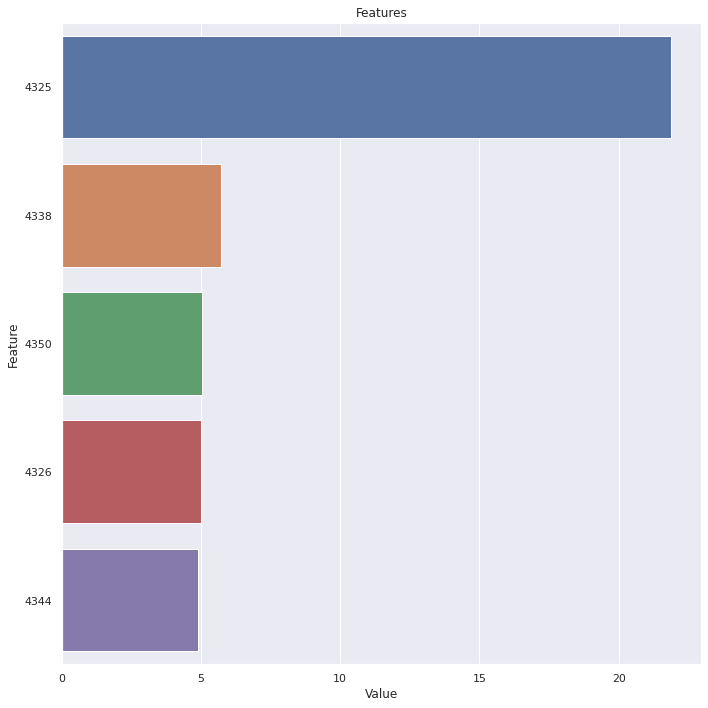

In [34]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(cat_model_final, X, num=5)

<h2 style=''>Thank you for your time. 💕</h2>